In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import hilbert,chirp
from scipy.stats import kurtosis,entropy
import scipy.io as sio
from scipy import stats
import time

# Data

 - Two simulation cases are considered in the paper
 -- Due to privivy issue, we do not provid the original data in real applications. 
 -- However, we provide the simulated data.
 -- The simulated data are generated by manipulating the original data in real applications.
 - This is the __FIRST__ case.

## load data

In [3]:
# path for loading the simulated data
path = r'F:\10-data fusion CORP WH2\案例-simu\simulated_data'
# path for saving results
path_save = r'F:\10-data fusion CORP WH2\案例-simu\results'
# data for illustration
df = pd.read_excel(path+'\wheel1_simulated.xlsx')
# data of wheel #1-4 for training
df_wheel1 = pd.read_excel(path+'\wheel1_simulated.xlsx')
df_wheel2 = pd.read_excel(path+'\wheel2_simulated.xlsx')
df_wheel3 = pd.read_excel(path+'\wheel3_simulated.xlsx')
df_wheel4 = pd.read_excel(path+'\wheel4_simulated.xlsx')
# data of wheel #5 for test
df_wheel5 = pd.read_excel(path+'\wheel5_simulated.xlsx')

## show original data

In [4]:
df1 = df

print('number of observations: ',df_wheel1.db.size)

number of observations:  10711


In [5]:
df_wheel1.head()

,Unnamed: 0,mileage,db
0,0,20,12.513511
1,1,40,11.747744
2,2,60,17.114142
3,3,80,26.361180
4,4,100,37.117974


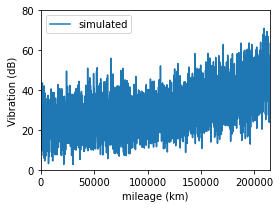

In [6]:
plt.rcParams["figure.figsize"] = (4,3)

plt.plot(df.mileage,df.db.rolling(4).mean(),label='simulated')

plt.xlabel('mileage (km)')
plt.ylabel('Vibration (dB)')
plt.ylim([0,80])
plt.xlim([0,215000])
plt.tight_layout()
plt.legend()

# Box-Cox transformation

- Technical details for Box-Cox transformation are provided in Section 3.1.1 in our paper

## illustration

- Given different values of $\alpha$, we calculate the 
-- $\lambda$ that maximizes the log-likelihood function; see the log-likelihood function is in Equation (4) in the paper
-- minimum and maximum confidence limits for $\lambda$; see technical details in Equation (5) in the paper

In [7]:
for alpha in [0.0001,0.9]:
    signal_boxcox,max_lambda,ci_lambda = stats.boxcox(df1.db,alpha=alpha)
    print('================================================')
    print('alpha= ',alpha)
    print('lambda:',max_lambda)
    print('ci_lambda',ci_lambda)

alpha=  0.0001
lambda: 0.6906063430259698
ci_lambda (0.6476293455120566, 0.7343300820201404)
alpha=  0.9
lambda: 0.6906063430259698
ci_lambda (0.6892065862799533, 0.6920068429441286)


## application

### DEF: Box Cox transformation for our data

- find the best value of $\lambda$ first, denoted as $\hat\lambda$

In [8]:
signal_boxcox,max_lambda,ci_lambda = stats.boxcox(df_wheel1.db.rolling(1).mean(),alpha=0.025)
print('=====================')
print('the best lambda:')
print('lambda:',max_lambda)
print('ci_lambda',ci_lambda)

the best lambda:
lambda: 0.6906063430259698
ci_lambda (0.6657561631849201, 0.7157043428165942)


- set different values of $\lambda$ around $\hat{\lambda}$

In [9]:
def box_cox_on_data(df):
    signal = df.db.rolling(4).mean()
    
    # first, calculate the best lambda
    signal_boxcox,max_lambda,ci_lambda = stats.boxcox(signal,alpha=0.025)
    print('=====================')
    print('the best lambda:')
    print('lambda:',max_lambda)
    print('ci_lambda',ci_lambda)

    lambdas = [0.3,0.4,0.5,0.65,0.7,0.8,0.9]
    # define the dataframe
    df_boxcox = pd.DataFrame({'mileage' : df.mileage})
    signals_names = []
    signals_var_names = []
    for lamb in lambdas:
        signal_boxcox = stats.boxcox(x = signal,lmbda = lamb)
        name = 'signal_boxcox_lamb'+str(lamb)
        signals_names.append(name)
        df_boxcox[name] = signal_boxcox
        name2 = 'signal_boxcox_var_lamb'+str(lamb)
        signals_var_names.append(name2)
        df_boxcox[name2] = df_boxcox[name].rolling(10).std()

    df_boxcox = df_boxcox.dropna() # drop the NaN
    df_boxcox = df_boxcox.reset_index()
    return df_boxcox,signals_names

### conduct box_cox transform on all wheels data

In [10]:
df_wheel1_boxcox,signals_names = box_cox_on_data(df_wheel1)
df_wheel2_boxcox,signals_names = box_cox_on_data(df_wheel2)
df_wheel3_boxcox,signals_names = box_cox_on_data(df_wheel3)
df_wheel4_boxcox,signals_names = box_cox_on_data(df_wheel4)
df_wheel5_boxcox,signals_names = box_cox_on_data(df_wheel5)

the best lambda:
lambda: 8.472135811722177
ci_lambda (1.9263406583655017e-12, 1.0200137480435589e-12)
the best lambda:
lambda: 8.472135811722177
ci_lambda (1.9263406583655017e-12, 1.0200137480435589e-12)
the best lambda:
lambda: 8.472135811722177
ci_lambda (1.9263406583655017e-12, 1.0200137480435589e-12)
the best lambda:
lambda: 8.472135811722177
ci_lambda (1.9263406583655017e-12, 1.0200137480435589e-12)
the best lambda:
lambda: 8.472135811722177
ci_lambda (1.9263406583655017e-12, 1.0200137480435589e-12)


### show the transformed data

the best lambda:
lambda: 8.472135811722177
ci_lambda (1.9263406583655017e-12, 1.0200137480435589e-12)


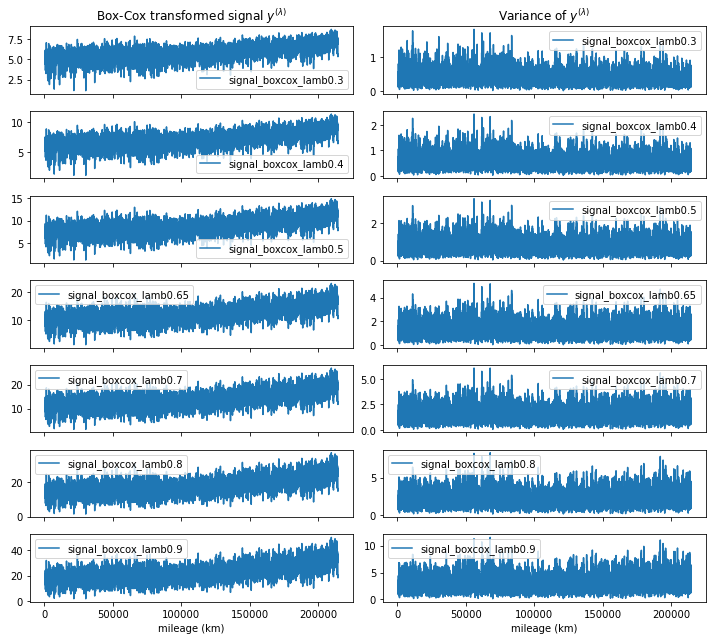

In [11]:
df_boxcox,signals_names = box_cox_on_data(df_wheel1)

fig,axs = plt.subplots(7,2,sharex = True, figsize=(10,9))

i = 0
for key in signals_names:
    axs[i,0].plot(df_boxcox['mileage'],df_boxcox[key], label = key)
    axs[i,1].plot(df_boxcox['mileage'],df_boxcox[key].rolling(4).std(), label = key)
    # axs[i,1].hist(df_boxcox[key], bins = 25, density = True, edgecolor = 'black',alpha = 0.8, label = key)
    i = i+1
    
axs[6,0].set_xlabel('mileage (km)')
axs[6,1].set_xlabel('mileage (km)')
axs[0,0].set_title('Box-Cox transformed signal $y^{(\lambda)}$')
axs[0,1].set_title('Variance of $y^{(\lambda)}$')


for axs in fig.get_axes():
    axs.legend()
    axs.set_xticks(np.arange(0,230000,50000))

plt.tight_layout()

plt.savefig(path_save+'\wheel1.png',dpi = 500)
plt.savefig(path_save+'\wheel1.svg',dpi = 500)

- have a look at the transformed data

In [12]:
df_wheel1_boxcox.head()

,index,mileage,signal_boxcox_lamb0.3,signal_boxcox_var_lamb0.3,signal_boxcox_lamb0.4,signal_boxcox_var_lamb0.4,signal_boxcox_lamb0.5,signal_boxcox_var_lamb0.5,signal_boxcox_lamb0.65,signal_boxcox_var_lamb0.65,signal_boxcox_lamb0.7,signal_boxcox_var_lamb0.7,signal_boxcox_lamb0.8,signal_boxcox_var_lamb0.8,signal_boxcox_lamb0.9,signal_boxcox_var_lamb0.9
0,12,260,4.924946,0.665993,5.880844,0.908380,7.072243,1.239570,9.445949,1.977692,10.436232,2.311474,12.797710,3.158639,15.785124,4.318273
1,13,280,5.637992,0.650622,6.859310,0.887289,8.415013,1.210624,11.604868,1.931140,12.965501,2.256929,16.269339,3.083744,20.550519,4.215416
2,14,300,5.725798,0.673060,6.981647,0.917795,8.585459,1.252080,11.885177,1.996743,13.296369,2.333355,16.730325,3.187426,21.192796,4.355990
3,15,320,5.030871,0.656719,6.024479,0.896041,7.267014,1.223157,9.753501,1.952523,10.794370,2.282451,13.283350,3.120051,16.443660,4.266968
4,16,340,5.596231,0.607723,6.801266,0.827118,8.334336,1.126216,11.472668,1.790860,12.809644,2.090755,16.052710,2.850541,20.249423,3.888110


In [13]:
print('signals_names:\n',signals_names)

signals_names:
 ['signal_boxcox_lamb0.3', 'signal_boxcox_lamb0.4', 'signal_boxcox_lamb0.5', 'signal_boxcox_lamb0.65', 'signal_boxcox_lamb0.7', 'signal_boxcox_lamb0.8', 'signal_boxcox_lamb0.9']


# N-Beats for prediction

In [16]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, layers
from keras.models import Sequential, Model

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import torch
from torch import optim
from torch.nn import functional
from nbeats_pytorch.model import NBeatsNet
from torch.nn import functional as F

from numpy.random import seed

from NBEATS import NeuralBeats

seed(1)

In [392]:
# pip install nbeats-keras

In [393]:
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch

## train the model

### check if the dataframe have the same length

In [17]:
print('======== some information about the original data ======')
dfs = [df_wheel1_boxcox,
       df_wheel2_boxcox,
       df_wheel3_boxcox,
       df_wheel4_boxcox]
for df in dfs:
    print('size:',df.mileage.size)

======== some information about the original data ======
size: 10699
size: 10699
size: 10699
size: 10699


### DEF: TrainTestData

In [21]:
def TrainTestData(forecast_length,backcast_length,dfs,lamb):
    forecast_length
    backcast_length
    idx1 = dfs[0].size
    idx2 = idx1+forecast_length

    # source domain data : lambda = 0.81
    lamb

    # generate the data into standard data shape
    x = []
    y = []
    t_x = []
    t_y = []
    for df in dfs:
        t = np.array(df.mileage)
        HI = np.array(df["signal_boxcox_lamb"+str(lamb)])
        for j in range(backcast_length,len(HI)-forecast_length,1):
            t_x.append(t[j-backcast_length:j].reshape(backcast_length,1))
            t_y.append(t[j:j+forecast_length].reshape(forecast_length,1))
            x.append(HI[j-backcast_length:j].reshape(backcast_length,1))
            y.append(HI[j:j+forecast_length].reshape(forecast_length,1))

        
    x = np.asarray(x) 
    y = np.asarray(y)
    t_x = np.asarray(t_x)
    t_y = np.asarray(t_y)
    
    # split data into training and testing datasets.
    # C is the number of total observations for four wheel
    # c is the numeber of observations of one wheel
    # w is the percent we want to use as training data
    C = x.shape[0]
    print('C - number of total observations for four wheel : ',C)
    c = int(C/4)
    print('c - numeber of observations of one wheel: ',c)
    w = int(c*0.8)
    print('w - the percent we want to use as training data: ',w)

    # concatenate the training data from four wheels
    x_train = np.concatenate((x[0:w],x[c:c+w],x[2*c:2*c+w],x[3*c:3*c+w]))
    y_train = np.concatenate((y[0:w],y[c:c+w],y[2*c:2*c+w],y[3*c:3*c+w]))\
    # concatenate the test data from four wheels
    x_test = np.concatenate((x[w:c],x[c+w:2*c],x[2*c+w:3*c],x[3*c+w:C]))
    y_test = np.concatenate((y[w:c],y[c+w:2*c],y[2*c+w:3*c],y[3*c+w:C]))

    # concatenate the mileages from training data of the four wheels
    t_x_train = np.concatenate((t_x[0:w],t_x[c:c+w],t_x[2*c:2*c+w],t_x[3*c:3*c+w]))
    t_y_train = np.concatenate((t_y[0:w],t_y[c:c+w],t_y[2*c:2*c+w],t_y[3*c:3*c+w]))
    # concatenate the mieages from the test data of the four wheels
    t_x_test = np.concatenate((t_x[w:c],t_x[c+w:2*c],t_x[2*c+w:3*c],t_x[3*c+w:C]))
    t_y_test = np.concatenate((t_y[w:c],t_y[c+w:2*c],t_y[2*c+w:3*c],t_y[3*c+w:C]))

    test_size = len(x_test)
    
    print('test_size = ',test_size)
    
    return x, y, t_x, t_y, x_train, y_train, x_test, y_test, t_x_train, t_y_train, t_x_test, t_y_test, t, HI

### train the model on training dataset

# !!!Notice: To Be Continued !!!
- The code from here may need revision

In [22]:
forecast_length = 20
backcast_length = 40
lamb = 0.65
x, y, t_x, t_y, x_train, y_train, x_test, y_test, t_x_train, t_y_train, t_x_test, t_y_test, t, HI = TrainTestData(forecast_length,
                                                                 backcast_length,
                                                                 dfs,
                                                                 lamb)

C - number of total observations for four wheel :  42556
c - numeber of observations of one wheel:  10639
w - the percent we want to use as training data:  8511
test_size =  8512


In [397]:
# NOTE: If you choose the Keras backend with input_dim>1, you have 
# to set the value here too (in the constructor).
output_dim = 1

test_size = 8512

backend = NBeatsKeras(          
    backcast_length=backcast_length, 
    forecast_length=forecast_length,            
    stack_types=(NBeatsKeras.GENERIC_BLOCK, NBeatsKeras.GENERIC_BLOCK),            
    nb_blocks_per_stack=6, 
    thetas_dim=(4, 4), 
    share_weights_in_stack=True,
    hidden_layer_units=8
)

# Definition of the objective function and the optimizer.
backend.compile(loss='mae', 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Train the model.
print('Training...')
backend.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=16)

# Save the model for later.
backend.save('n_beats_model_trained_on_lam'+str(lamb)+'.h5')
backend.save('n_beats_model.h5')

# Predict on the testing set (forecast).
predictions_forecast = backend.predict(x_test)
np.testing.assert_equal(predictions_forecast.shape, (test_size, backend.forecast_length, output_dim))

# Predict on the testing set (backcast).
predictions_backcast = backend.predict(x_test, return_backcast=True)
np.testing.assert_equal(predictions_backcast.shape, (test_size, backend.backcast_length, output_dim))

# Load the model.
model_2 = NBeatsKeras.load('n_beats_model_trained_on_lam'+str(lamb)+'.h5')

np.testing.assert_almost_equal(predictions_forecast, model_2.predict(x_test))

Training...
Epoch 1/20
2128/2128 [==============================] - 5s 2ms/step - loss: 1.9740 - val_loss: 2.2465
Epoch 2/20
2128/2128 [==============================] - 3s 1ms/step - loss: 1.6140 - val_loss: 2.1886
Epoch 3/20
2128/2128 [==============================] - 3s 1ms/step - loss: 1.6004 - val_loss: 2.4603
Epoch 4/20
2128/2128 [==============================] - 3s 2ms/step - loss: 1.5797 - val_loss: 2.2011
Epoch 5/20
2128/2128 [==============================] - 3s 1ms/step - loss: 1.5700 - val_loss: 2.2019
Epoch 6/20
2128/2128 [==============================] - 3s 1ms/step - loss: 1.5674 - val_loss: 2.3130
Epoch 7/20
2128/2128 [==============================] - 3s 1ms/step - loss: 1.5642 - val_loss: 2.2673
Epoch 8/20
2128/2128 [==============================] - 3s 1ms/step - loss: 1.5634 - val_loss: 2.3149
Epoch 9/20
2128/2128 [==============================] - 3s 1ms/step - loss: 1.5621 - val_loss: 2.3141
Epoch 10/20
2128/2128 [==============================] - 3s 1ms/step -

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [320]:
backend.summary()

Model: "forecast"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_variable (InputLayer)    [(None, 40, 1)]      0           []                               
                                                                                                  
 lambda_1 (Lambda)              (None, 40)           0           ['input_variable[0][0]']         
                                                                                                  
 0/0/generic/d1 (Dense)         (None, 8)            328         ['lambda_1[0][0]',               
                                                                  'subtract_12[0][0]',            
                                                                  'subtract_13[0][0]',            
                                                                  'subtract_14[0][0]',     

### perfomance of the trained model on test data

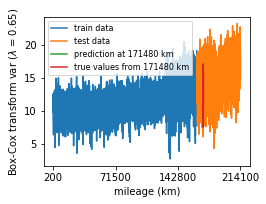

In [398]:
# this is the index, where the data before it is used for training, and the data after it is used for testing
idx4 = 8200

plt.figure(figsize=(3.8,2.8))

plt.plot(t[0:idx4],HI[0:idx4],label='train data')
plt.plot(t[idx4:],HI[idx4:],label='test data')

for i in [10]:
    # plt.plot(t_x_test[i],x_test[i])
    plt.plot(t_y_test[i],predictions_forecast[i],label='prediction at '+str(int(t_y_test[i][0][0]))+' km')
    plt.plot(t_y_test[i],y_test[i],label='true values from '+str(int(t_y_test[i][0][0]))+' km')

plt.xlabel('mileage (km)')
plt.ylabel('Box-Cox transform var ($\lambda$ = '+str(lamb)+')')

plt.xticks(np.arange(int(np.min(df_boxcox.mileage)/100)*100, np.max(df_boxcox.mileage), int((np.max(df_boxcox.mileage)-np.min(df_boxcox.mileage))/300)*100))

plt.tight_layout()

plt.legend(fontsize=8)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_'+str(lamb)+'_prediction_at'+str(int(t_y_test[i][0]))+'.png',dpi=500)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_'+str(lamb)+'_prediction_at'+str(int(t_y_test[i][0]))+'.svg',dpi=500)

8512


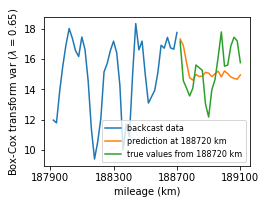

In [399]:
print(len(x_test))

plt.figure(figsize=(3.8,2.8))

for i in [3000]:
    plt.plot(t_x_test[i],x_test[i],label='backcast data')
    plt.plot(t_y_test[i],predictions_forecast[i],label='prediction at '+str(int(t_y_test[i][0][0]))+' km')
    plt.plot(t_y_test[i],y_test[i],label='true values from '+str(int(t_y_test[i][0][0]))+' km')

    
plt.xticks(np.arange(int(np.min(t_x_test[i])/100)*100, np.max(t_y_test[i]+100), int((np.max(t_y_test[i])-np.min(t_x_test[i]))/250)*100))

    
plt.xlabel('mileage (km)')
plt.ylabel('Box-Cox transform var ($\lambda$ = '+str(lamb)+')')

plt.tight_layout()

plt.legend(fontsize=8)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_'+str(lamb)+'_prediction_at'+str(int(t_y_test[i][0]))+'_zoomin.png',dpi=500)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_'+str(lamb)+'_prediction_at'+str(int(t_y_test[i][0]))+'_zoomin.svg',dpi=500)

## transfer learning with fine tuning

### define the data we want to transfer our trained_model

In [400]:
forecast_length = 20
backcast_length = 40
lamb = 0.4
results = TrainTestData(forecast_length,
                        backcast_length,
                        [df_wheel5_boxcox],
                        lamb)

x_transfer = results[0]
y_transfer = results[1]
t_x_transfer = results[2]
t_y_transfer = results[3]
x_train_transfer = results[4] 
y_train_transfer = results[5]
x_test_transfer = results[6]
y_test_transfer = results[7]
t_x_train_transfer = results[8] 
t_y_train_transfer = results[9] 
t_x_test_transfer = results[10] 
t_y_test_transfer = results[11]

C:  10639
c:  2659
w:  2127
test_size =  2131


### fine tuning the trained model

In [401]:
# Load the model.
model_trained = NBeatsKeras.load('n_beats_model.h5')

In [402]:
# See what the model look like
model_trained.summary()
# model_trained.layers[-3]

Model: "forecast"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_variable (InputLayer)    [(None, 40, 1)]      0           []                               
                                                                                                  
 lambda_2 (Lambda)              (None, 40)           0           ['input_variable[0][0]']         
                                                                                                  
 0/0/generic/d1 (Dense)         (None, 8)            328         ['lambda_2[0][0]',               
                                                                  'subtract_24[0][0]',            
                                                                  'subtract_25[0][0]',            
                                                                  'subtract_26[0][0]',     

In [403]:
model_trained.trainable = False
model_trained.layers[-6].trainable = True
model_trained.layers[-3].trainable = True
print(model_trained.trainable)
print(model_trained.layers[-6].trainable)

False
True


In [404]:
# Train the model.
print('Re-Training...')
    
history = model_trained.fit(x_train_transfer, 
                  y_train_transfer, 
                  validation_data=(x_test_transfer, y_test_transfer), 
                  epochs=4, 
                  batch_size=16)

# Save the model for later.
model_trained.save('n_beats_model_transfer.h5')

# Predict on the testing set (forecast).
predictions_forecast_transfer = model_trained.predict(x_test_transfer)

Re-Training...
Epoch 1/4
532/532 [==============================] - 2s 2ms/step - loss: 0.7016 - val_loss: 0.7058
Epoch 2/4
532/532 [==============================] - 1s 1ms/step - loss: 0.6927 - val_loss: 0.6940
Epoch 3/4
532/532 [==============================] - 1s 1ms/step - loss: 0.6919 - val_loss: 0.7002
Epoch 4/4
532/532 [==============================] - 1s 1ms/step - loss: 0.6915 - val_loss: 0.6922


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### plot

2131


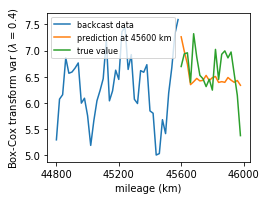

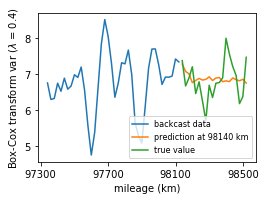

In [405]:
print(len(x_test_transfer))

for i in range(100,1000,500):
    plt.figure(figsize=(3.8,2.8))
    plt.plot(t_x_test_transfer[i],x_test_transfer[i],label='backcast data')
    # plt.plot(t_y_test[i],predictions_forecast[i],label='predicted')
    plt.plot(t_y_test_transfer[i],predictions_forecast_transfer[i],label='prediction at '+str(int(t_y_test_transfer[i][0]))+ ' km')
    plt.plot(t_y_test_transfer[i],y_test_transfer[i],label='true value')

    plt.xticks(np.arange(int(np.min(t_x_test_transfer[i])/100)*100, np.max(t_y_test_transfer[i]+100), int((np.max(t_y_test_transfer[i])-np.min(t_x_test_transfer[i]))/250)*100))

    plt.xlabel('mileage (km)')
    plt.ylabel('Box-Cox transform var ($\lambda$ = '+str(lamb)+')')

    plt.tight_layout()

    plt.legend(fontsize=8)
    plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_'+str(lamb)+'_prediction_at'+str(int(t_y_test_transfer[i][0]))+'_zoomin.png',dpi=500)
    plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_'+str(lamb)+'_prediction_at'+str(int(t_y_test_transfer[i][0]))+'_zoomin.svg',dpi=500)

## predict feature on wheel5

### load the trained model on dataset {wheel1-4} lambda=0.81

In [406]:
lamb = 0.65
model_trained = NBeatsKeras.load('n_beats_model_trained_on_lam'+str(lamb)+'.h5')

### define the data of wheel5

In [419]:
idx0 = 0
forecast_length = 20
backcast_length = 40
idx1 = df_wheel1_boxcox.size
idx2 = idx1+forecast_length

# source domain data : lambda = 0.81

# define the target domain data
lamb = 0.8

# generate the data into standard data shape
x_transfer = []
y_transfer = []
t_x_transfer = []
t_y_transfer = []
for df in [df_wheel5_boxcox]:
    t_transfer = np.array(df.mileage[idx0:idx1])
    HI_transfer = np.array(df["signal_boxcox_lamb"+str(lamb)][idx0:idx1])
    for j in range(backcast_length,len(HI_transfer)-forecast_length,forecast_length):
        t_x_transfer.append(t_transfer[j-backcast_length:j].reshape(backcast_length,1))
        t_y_transfer.append(t_transfer[j:j+forecast_length].reshape(forecast_length,1))
        x_transfer.append(HI_transfer[j-backcast_length:j].reshape(backcast_length,1))
        y_transfer.append(HI_transfer[j:j+forecast_length].reshape(forecast_length,1))

        
x_transfer = np.asarray(x_transfer) 
y_transfer = np.asarray(y_transfer)
t_x_transfer = np.asarray(t_x_transfer)
t_y_transfer = np.asarray(t_y_transfer)

C = x_transfer.shape[0] // 10*3

x_train_transfer, y_train_transfer, x_test_transfer, y_test_transfer =  x_transfer[:C], y_transfer[:C], x_transfer[C:], y_transfer[C:]
t_x_train_transfer, t_y_train_transfer, t_x_test_transfer, t_y_test_transfer = t_x_transfer[:C], t_y_transfer[:C], t_x_transfer[C:], t_y_transfer[C:]

### fine tuning the trained model with some data on wheel5

In [420]:
model_trained.trainable = False
model_trained.layers[-6].trainable = True
model_trained.layers[-3].trainable = True
print(model_trained.trainable)
print(model_trained.layers[-6].trainable)

False
True


In [421]:
# Train the model.
print('Re-Training...')
    
history = model_trained.fit(x_train_transfer, 
                  y_train_transfer, 
                  validation_data=(x_test_transfer, y_test_transfer), 
                  epochs=4, 
                  batch_size=16)

# Save the model for later.
model_trained.save('n_beats_model_transfer.h5')

# Predict on the testing set (forecast).
predictions_forecast_transfer = model_trained.predict(x_test_transfer)

Re-Training...
Epoch 1/4
10/10 [==============================] - 0s 6ms/step - loss: 2.5477 - val_loss: 3.1335
Epoch 2/4
10/10 [==============================] - 0s 4ms/step - loss: 2.1804 - val_loss: 3.0012
Epoch 3/4
10/10 [==============================] - 0s 5ms/step - loss: 2.1205 - val_loss: 2.9041
Epoch 4/4
10/10 [==============================] - 0s 5ms/step - loss: 2.0946 - val_loss: 2.9425


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### plot the prediction result

10699


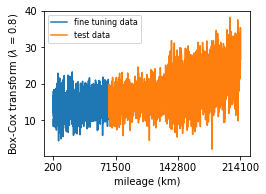

In [422]:
plt.figure(figsize=(3.8,2.8))

idx5 = C*forecast_length

print(t_transfer.size)

plt.plot(t_transfer[0:idx5],HI_transfer[0:idx5],label='fine tuning data')
plt.plot(t_transfer[idx5:],HI_transfer[idx5:],label='test data')
 
plt.xlabel('mileage (km)')
plt.ylabel('Box-Cox transform ($\lambda$ = '+str(lamb)+')')

plt.xticks(np.arange(int(np.min(df_boxcox.mileage)/100)*100, np.max(df_boxcox.mileage), int((np.max(df_boxcox.mileage)-np.min(df_boxcox.mileage))/300)*100))

plt.tight_layout()

plt.legend(fontsize=8)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_'+str(lamb)+'_prediction_at'+str(int(t_transfer[idx5]))+'.png',dpi=500)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_'+str(lamb)+'_prediction_at'+str(int(t_transfer[idx5]))+'.svg',dpi=500)

- np.concatenate the test data

In [423]:
x_test_transfer = x_test_transfer.reshape((-1,1))
t_x_test_transfer = t_x_test_transfer.reshape((-1,1))
t_y_test_transfer = t_y_test_transfer.reshape((-1,1))
predictions_forecast_transfer = predictions_forecast_transfer.reshape((-1,1))
y_test_transfer = y_test_transfer.reshape((-1,1))

print(t_x_test_transfer.shape)
print(x_test_transfer.shape)

(14920, 1)
(14920, 1)


14920


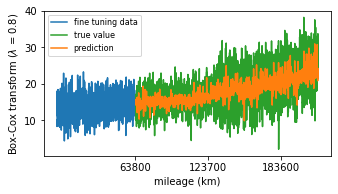

In [424]:
print(len(x_test_transfer))

plt.figure(figsize=(4.8,2.8))

plt.plot(t_transfer[0:idx5],HI_transfer[0:idx5],label='fine tuning data')
plt.plot(t_y_test_transfer,y_test_transfer,label='true value',color='tab:green')
plt.plot(t_y_test_transfer,predictions_forecast_transfer,label='prediction',color='tab:orange')

plt.xticks(np.arange(int(np.min(t_x_test_transfer)/100)*100, np.max(t_y_test_transfer+100), int((np.max(t_y_test_transfer)-np.min(t_x_test_transfer))/250)*100))

plt.xlabel('mileage (km)')
plt.ylabel('Box-Cox transform ($\lambda$ = '+str(lamb)+')')

plt.tight_layout()

plt.legend(fontsize=8)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_'+str(lamb)+'_prediction_at'+str(int(t_y_test_transfer[i][0]))+'_zoomin.png',dpi=500)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_'+str(lamb)+'_prediction_at'+str(int(t_y_test_transfer[i][0]))+'_zoomin.svg',dpi=500)

# revese of the boxcox transformed signals

## reverse each of the feature

In [336]:
from scipy.special import inv_boxcox

In [337]:
lambdas = [0.3,0.4,0.5,0.65,0.7,0.8,0.9]

In [338]:
idx0 = 0
forecast_length = 20
backcast_length = 40
idx1 = df_wheel1_boxcox.size
idx2 = idx1+forecast_length

results = {}

# source domain data : lambda = 0.81

# define the target domain data
for lamb in lambdas:
    # generate the data into standard data shape
    x_transfer = []
    y_transfer = []
    t_x_transfer = []
    t_y_transfer = []
    for df in [df_wheel5_boxcox]:
        t_transfer = np.array(df.mileage[idx0:idx1])
        HI_transfer = np.array(df["signal_boxcox_lamb"+str(lamb)][idx0:idx1])
        for j in range(backcast_length,len(HI_transfer)-forecast_length,forecast_length):
            t_x_transfer.append(t_transfer[j-backcast_length:j].reshape(backcast_length,1))
            t_y_transfer.append(t_transfer[j:j+forecast_length].reshape(forecast_length,1))
            x_transfer.append(HI_transfer[j-backcast_length:j].reshape(backcast_length,1))
            y_transfer.append(HI_transfer[j:j+forecast_length].reshape(forecast_length,1))

    x_transfer = np.asarray(x_transfer) 
    y_transfer = np.asarray(y_transfer)
    t_x_transfer = np.asarray(t_x_transfer)
    t_y_transfer = np.asarray(t_y_transfer)

    C = x_transfer.shape[0] // 10*3

    x_train_transfer, y_train_transfer, x_test_transfer, y_test_transfer =  x_transfer[:C], y_transfer[:C], x_transfer[C:], y_transfer[C:]
    t_x_train_transfer, t_y_train_transfer, t_x_test_transfer, t_y_test_transfer = t_x_transfer[:C], t_y_transfer[:C], t_x_transfer[C:], t_y_transfer[C:]

    model_trained.trainable = False
    model_trained.layers[-6].trainable = True
    model_trained.layers[-3].trainable = True
    print(model_trained.trainable)
    print(model_trained.layers[-6].trainable)

    # Train the model.
    print('Re-Training...')
    
    history = model_trained.fit(x_train_transfer, 
                  y_train_transfer, 
                  validation_data=(x_test_transfer, y_test_transfer), 
                  epochs=4, 
                  batch_size=16)

    # Save the model for later.
    model_trained.save('n_beats_model_transfer.h5')

    # Predict on the testing set (forecast).
    predictions_forecast_transfer = model_trained.predict(x_test_transfer)

    x_test_transfer = x_test_transfer.reshape((-1,1))
    t_x_test_transfer = t_x_test_transfer.reshape((-1,1))
    t_y_test_transfer = t_y_test_transfer.reshape((-1,1))
    predictions_forecast_transfer = predictions_forecast_transfer.reshape((-1,1))
    y_test_transfer = y_test_transfer.reshape((-1,1))

    y_test_transfer_inv = inv_boxcox(y_test_transfer, lamb)
    predictions_forecast_transfer_inv = inv_boxcox(predictions_forecast_transfer, lamb)
    HI_transfer_inv = inv_boxcox(HI_transfer, lamb)

    # save the inversed data
    results['predictions_forecast_transfer_inv'+str(lamb)] = predictions_forecast_transfer_inv.reshape((-1))

print(results)

False
True
Re-Training...
Epoch 1/4
10/10 [==============================] - 0s 6ms/step - loss: 1.9921 - val_loss: 0.6161
Epoch 2/4
10/10 [==============================] - 0s 4ms/step - loss: 0.7533 - val_loss: 0.8678
Epoch 3/4
10/10 [==============================] - 0s 4ms/step - loss: 0.7378 - val_loss: 0.7825
Epoch 4/4
10/10 [==============================] - 0s 4ms/step - loss: 0.6898 - val_loss: 0.6623
False
True
Re-Training...
Epoch 1/4
10/10 [==============================] - 0s 6ms/step - loss: 0.9957 - val_loss: 0.7862
Epoch 2/4
 1/10 [==>...........................] - ETA: 0s - loss: 0.8615

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


10/10 [==============================] - 0s 4ms/step - loss: 0.9301 - val_loss: 0.7780
Epoch 3/4
10/10 [==============================] - 0s 4ms/step - loss: 0.9118 - val_loss: 0.7883
Epoch 4/4
10/10 [==============================] - 0s 4ms/step - loss: 0.8986 - val_loss: 0.7437
False
True
Re-Training...
Epoch 1/4
10/10 [==============================] - 0s 6ms/step - loss: 1.2664 - val_loss: 0.9590
Epoch 2/4
10/10 [==============================] - 0s 4ms/step - loss: 1.2209 - val_loss: 0.9532
Epoch 3/4
10/10 [==============================] - 0s 5ms/step - loss: 1.2122 - val_loss: 0.9895
Epoch 4/4
10/10 [==============================] - 0s 4ms/step - loss: 1.2071 - val_loss: 0.9416
False
True
Re-Training...
Epoch 1/4
10/10 [==============================] - 0s 6ms/step - loss: 2.0110 - val_loss: 1.4391
Epoch 2/4
10/10 [==============================] - 0s 4ms/step - loss: 1.9411 - val_loss: 1.5789
Epoch 3/4
10/10 [==============================] - 0s 4ms/step - loss: 1.9318 - val_l

In [339]:
inv_boxcox(y_test_transfer, lamb)

array([[13.7375532 ],
       [ 9.48937647],
       [ 8.44435872],
       ...,
       [48.40807567],
       [47.43817919],
       [47.21110504]])

14920


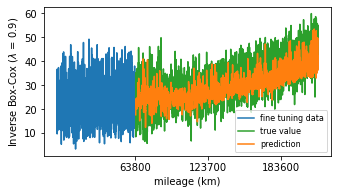

In [340]:
print(len(x_test_transfer))

plt.figure(figsize=(4.8,2.8))

plt.plot(t_transfer[0:idx5],HI_transfer_inv[0:idx5],label='fine tuning data')
plt.plot(t_y_test_transfer,y_test_transfer_inv,label='true value',color='tab:green')
plt.plot(t_y_test_transfer,predictions_forecast_transfer_inv,label='prediction',color='tab:orange')

plt.xticks(np.arange(int(np.min(t_x_test_transfer)/100)*100, np.max(t_y_test_transfer+100), int((np.max(t_y_test_transfer)-np.min(t_x_test_transfer))/250)*100))

plt.xlabel('mileage (km)')
plt.ylabel('Inverse Box-Cox ($\lambda$ = '+str(lamb)+')')

plt.tight_layout()

plt.legend(fontsize=8)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_inv_'+str(lamb)+'_prediction_at'+str(int(t_y_test_transfer[i][0]))+'.png',dpi=500)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_inv_'+str(lamb)+'_prediction_at'+str(int(t_y_test_transfer[i][0]))+'.svg',dpi=500)

## signal fusion

### recovered signal

- calculate the mean value of all recovered signals

In [341]:
results_mean = pd.DataFrame.from_dict(results).mean(1)

print(results_mean)

0       18.640547
1       20.222662
2       21.158213
3       23.915205
4       22.891474
          ...    
7455    36.777214
7456    36.381306
7457    34.926418
7458    34.527477
7459    34.245819
Length: 7460, dtype: float32


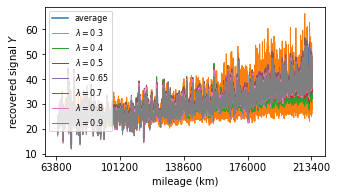

In [342]:
plt.figure(figsize=(4.8,2.8))

lambdas_inv = [0.3,0.4,0.5,0.65,0.7,0.8,0.9]

plt.plot(t_y_test_transfer,results_mean,label='average')

for lamb in lambdas_inv:
    plt.plot(t_y_test_transfer,
             results['predictions_forecast_transfer_inv'+str(lamb)],
             label='$\lambda=$'+str(lamb),linewidth=1)
    
plt.xticks(np.arange(int(np.min(t_x_test_transfer)/100)*100, np.max(t_y_test_transfer+100), int((np.max(t_y_test_transfer)-np.min(t_x_test_transfer))/400)*100))

plt.xlabel('mileage (km)')
plt.ylabel('recovered signal $Y$')

plt.tight_layout()

plt.legend(fontsize=8)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_inv_all_lambdas_prediction_at'+str(int(t_y_test_transfer[i][0]))+'.png',dpi=500)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_inv_all_lambdas_prediction_at'+str(int(t_y_test_transfer[i][0]))+'.svg',dpi=500)

### distribution of recovered  signals

In [343]:
import seaborn as sns

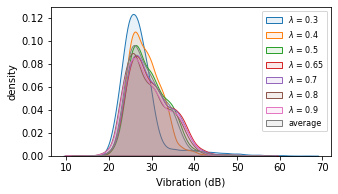

In [344]:
plt.figure(figsize=(4.8,2.8))

lambdas_inv = [0.3,0.4,0.5,0.65,0.7,0.8,0.9]

for lamb in lambdas_inv:
    sns.kdeplot(data = results['predictions_forecast_transfer_inv'+str(lamb)],
                fill = True,
                alpha = 0.1,
                palette="Paired",
                linewidth = 1,
                label = '$\lambda$ = '+str(lamb))

sns.kdeplot(data = results_mean,
                fill = True,
                alpha = 0.1,
                palette="Paired",
                linewidth = 1,
                label = 'average')
    
#plt.xticks(np.arange(int(np.min(t_x_test_transfer)/100)*100, np.max(t_y_test_transfer+100), int((np.max(t_y_test_transfer)-np.min(t_x_test_transfer))/400)*100))

plt.xlabel('Vibration (dB)')
plt.ylabel('density')

plt.tight_layout()

plt.legend(fontsize=8)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_inv_all_lambdas_prediction_at'+str(int(t_y_test_transfer[i][0]))+'_dist.png',dpi=500)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\bc_inv_all_lambdas_prediction_at'+str(int(t_y_test_transfer[i][0]))+'_dist.svg',dpi=500)

# fault time prediction

## fault alarm on predictions

### [DEF] alarm

In [345]:
threshold = 44
def alarm(results,lamb):
    signal_lamb = results['predictions_forecast_transfer_inv'+str(lamb)] 
    diff = signal_lamb-threshold
    alarm_num = []
    for j in range(0,len(diff),1):
        diff_uptoj = diff[0:j]
        cum_num = diff_uptoj[diff_uptoj>0]
        alarm_num.append(len(cum_num))

    return alarm_num

### calculate the true cumulative number

In [346]:
signal_lamb = df_wheel5_simu.db.rolling(30).mean()
# signal_lamb = df_wheel5_boxcox['signal_boxcox_lamb1']
diff = signal_lamb-threshold
alarm_num_true = []
for j in range(0,len(diff),1):
    diff_uptoj = diff[0:j]
    cum_num = diff_uptoj[diff_uptoj>0]
    alarm_num_true.append(len(cum_num))

### calculate the cumulative based on mean

In [347]:
signal_lamb = results_mean
diff = signal_lamb-threshold
alarm_num_mean = []
for j in range(0,len(diff),1):
    diff_uptoj = diff[0:j]
    cum_num = diff_uptoj[diff_uptoj>0]
    alarm_num_mean.append(len(cum_num))

### plot result

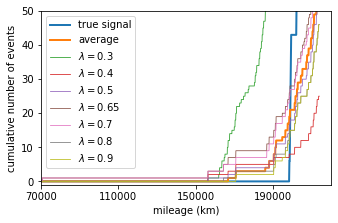

In [348]:
plt.figure(figsize=(4.8,3.2))

# plt.plot(df_wheel5_boxcox.mileage,alarm_num_true,label='true signal')

plt.plot(df_wheel5_simu.mileage,alarm_num_true,label='true signal',linewidth=2)
plt.plot(t_y_test_transfer,alarm_num_mean,label='average',linewidth=2)
for lamb in lambdas:
    alarm_num = alarm(results,lamb)
    plt.plot(t_y_test_transfer,alarm_num,label='$\lambda = $'+str(lamb),linewidth=0.8)
 
plt.xticks(np.arange(70000,230000,40000))

plt.xlim([70000,220000])
plt.ylim([-1,50])

plt.xlabel('mileage (km)')
plt.ylabel('cumulative number of events')

plt.legend()
plt.tight_layout()

plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\alarm_num.png',dpi=500)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\alarm_num.svg',dpi=500)

In [349]:
print(len(alarm_num))

print(len(t_y_test_transfer))

7460
7460


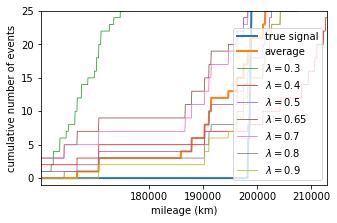

In [350]:
plt.figure(figsize=(4.8,3.2))

# plt.plot(df_wheel5_boxcox['mileage'],alarm_num_true,label='true signal')
plt.plot(df_wheel5.mileage,alarm_num_true,label='true signal',linewidth=2)
plt.plot(t_y_test_transfer,alarm_num_mean,label='average',linewidth=2)
for lamb in lambdas:
    alarm_num = alarm(results,lamb)
    plt.plot(t_y_test_transfer,alarm_num,label='$\lambda = $'+str(lamb),linewidth=0.8)

plt.xticks(np.arange(180000,230000,10000))
    
plt.xlabel('mileage (km)')
plt.ylabel('cumulative number of events')

plt.ylim([-1,25])
plt.xlim([160000,213000])
plt.legend()

plt.tight_layout()

plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\alarm_num_zoomin.png',dpi=500)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\alarm_num_zoomin.svg',dpi=500)

### prediction on failure time

lamb: 0.3    failure_time: 161880
lamb: 0.4    failure_time: 156300
lamb: 0.5    failure_time: 166680
lamb: 0.65    failure_time: 156280
lamb: 0.7    failure_time: 156280
lamb: 0.8    failure_time: 170680
lamb: 0.9    failure_time: 170700
lamb: 0.3    failure_time: 162280
lamb: 0.4    failure_time: 166680
lamb: 0.5    failure_time: 170680
lamb: 0.65    failure_time: 156300
lamb: 0.7    failure_time: 156300
lamb: 0.8    failure_time: 170700
lamb: 0.9    failure_time: 190280
lamb: 0.3    failure_time: 162300
lamb: 0.4    failure_time: 170680
lamb: 0.5    failure_time: 170700
lamb: 0.65    failure_time: 164280
lamb: 0.7    failure_time: 164280
lamb: 0.8    failure_time: 190280
lamb: 0.9    failure_time: 190300
lamb: 0.3    failure_time: 163480
lamb: 0.4    failure_time: 170700
lamb: 0.5    failure_time: 187880
lamb: 0.65    failure_time: 164300
lamb: 0.7    failure_time: 164300
lamb: 0.8    failure_time: 190300
lamb: 0.9    failure_time: 191080
lamb: 0.3    failure_time: 163500
lamb: 0.4 

C:\Users\yanbi\AppData\Local\Temp/ipykernel_23192/398809130.py:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


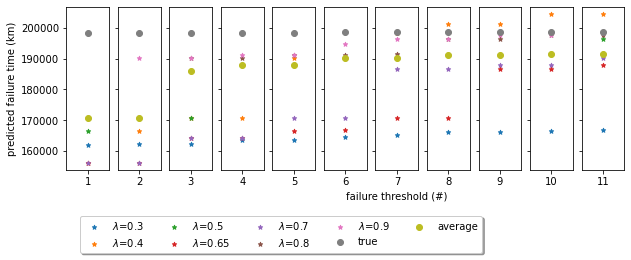

In [352]:
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(10, 3), sharey=True)

failure_counts = [1,2,3,4,5,6,7,8,9,10,11]
i = 0
# lambdas = [0.3,0.5,0.65,0.7,0.8,0.9]

for failure_count in failure_counts:  
    alarm_num_true = pd.Series(alarm_num_true)
    alarm_num_mean = pd.Series(alarm_num_mean)
    failure_index_true = alarm_num_true[alarm_num_true>failure_count].index[0]
    failure_time_true = df_wheel5_simu.mileage[failure_index_true]
    failure_index_mean = alarm_num_mean[alarm_num_mean>failure_count].index[0]
    failure_time_mean = t_y_test_transfer[failure_index_mean]

    if i == 0:
        for lamb in lambdas:
            alarm_num = alarm(results,lamb)
            alarm_num = pd.Series(alarm_num)
            failure_index = alarm_num[alarm_num>failure_count].index[0]
            failure_time = t_y_test_transfer[failure_index][0]
            print('lamb:',lamb,'   failure_time:',failure_time)  
            axs[i].scatter(failure_count,failure_time,s=20,marker='*',label='$\lambda$='+str(lamb))
    
        axs[i].scatter(failure_count,failure_time_true,label='true')
        axs[i].scatter(failure_count,failure_time_mean,label='average')
        axs[i].set_xticks([failure_count])
        
    else:
        for lamb in lambdas:
            alarm_num = alarm(results,lamb)
            alarm_num = pd.Series(alarm_num)
            failure_index = alarm_num[alarm_num>failure_count].index[0]
            failure_time = t_y_test_transfer[failure_index][0]
            print('lamb:',lamb,'   failure_time:',failure_time)  
            axs[i].scatter(failure_count,failure_time,s=20,marker='*')
    
        axs[i].scatter(failure_count,failure_time_true,label='true')
        axs[i].scatter(failure_count,failure_time_mean,label='average')
        axs[i].set_xticks([failure_count])
        
        
    i = i+1

axs[0].legend(loc='upper center', bbox_to_anchor=(5, -0.25),
          fancybox=True, shadow=True, ncol=5)

axs[6].set_xlabel('failure threshold (#)')
axs[0].set_ylabel('predicted failure time (km)')

fig.tight_layout()


plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\fault_prediction.png',dpi=500)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\fault_prediction.svg',dpi=500, bbox_inches='tight')

### plot on absolute error

lamb: 0.3    failure_time: 161880
lamb: 0.4    failure_time: 156300
lamb: 0.5    failure_time: 166680
lamb: 0.65    failure_time: 156280
lamb: 0.7    failure_time: 156280
lamb: 0.8    failure_time: 170680
lamb: 0.9    failure_time: 170700
lamb: 0.3    failure_time: 162280
lamb: 0.4    failure_time: 166680
lamb: 0.5    failure_time: 170680
lamb: 0.65    failure_time: 156300
lamb: 0.7    failure_time: 156300
lamb: 0.8    failure_time: 170700
lamb: 0.9    failure_time: 190280
lamb: 0.3    failure_time: 162300
lamb: 0.4    failure_time: 170680
lamb: 0.5    failure_time: 170700
lamb: 0.65    failure_time: 164280
lamb: 0.7    failure_time: 164280
lamb: 0.8    failure_time: 190280
lamb: 0.9    failure_time: 190300
lamb: 0.3    failure_time: 163480
lamb: 0.4    failure_time: 170700
lamb: 0.5    failure_time: 187880
lamb: 0.65    failure_time: 164300
lamb: 0.7    failure_time: 164300
lamb: 0.8    failure_time: 190300
lamb: 0.9    failure_time: 191080
lamb: 0.3    failure_time: 163500
lamb: 0.4 

C:\Users\yanbi\AppData\Local\Temp/ipykernel_23192/1774966070.py:47: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


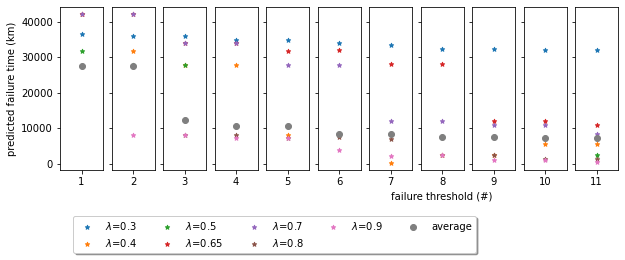

In [353]:
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(10, 3), sharey=True)

failure_counts = [1,2,3,4,5,6,7,8,9,10,11]
i = 0

for failure_count in failure_counts:  
    alarm_num_true = pd.Series(alarm_num_true)
    alarm_num_mean = pd.Series(alarm_num_mean)
    failure_index_true = alarm_num_true[alarm_num_true>failure_count].index[0]
    failure_time_true = df_wheel5_simu.mileage[failure_index_true]
    failure_index_mean = alarm_num_mean[alarm_num_mean>failure_count].index[0]
    failure_time_mean = t_y_test_transfer[failure_index_mean]

    if i == 0:
        for lamb in lambdas:
            alarm_num = alarm(results,lamb)
            alarm_num = pd.Series(alarm_num)
            failure_index = alarm_num[alarm_num>failure_count].index[0]
            failure_time = t_y_test_transfer[failure_index][0]
            print('lamb:',lamb,'   failure_time:',failure_time)  
            axs[i].scatter(failure_count,np.abs(failure_time-failure_time_true),s=20,marker='*',label='$\lambda$='+str(lamb))
    
        axs[i].scatter(failure_count,np.abs(failure_time_mean-failure_time_true),label='average')
        axs[i].set_xticks([failure_count])
        
    else:
        for lamb in lambdas:
            alarm_num = alarm(results,lamb)
            alarm_num = pd.Series(alarm_num)
            failure_index = alarm_num[alarm_num>failure_count].index[0]
            failure_time = t_y_test_transfer[failure_index][0]
            print('lamb:',lamb,'   failure_time:',failure_time)  
            axs[i].scatter(failure_count,np.abs(failure_time-failure_time_true),s=20,marker='*')
    
        axs[i].scatter(failure_count,np.abs(failure_time_mean-failure_time_true),label='average')
        axs[i].set_xticks([failure_count])
        
        
    i = i+1

axs[0].legend(loc='upper center', bbox_to_anchor=(5, -0.25),
          fancybox=True, shadow=True, ncol=5)

axs[7].set_xlabel('failure threshold (#)')
axs[0].set_ylabel('predicted failure time (km)')

fig.tight_layout()


plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\fault_prediction_AE.png',dpi=500)
plt.savefig(r'F:\10-data fusion CORP WH2\案例-simu\fault_prediction_AE.svg',dpi=500, bbox_inches='tight')

# END